### Preamble: imports

In [21]:
import random
import glob
import sys

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

In [3]:
from vggishembed import get_embed

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### In this notebook we'll train a classifier to indentify laughter vs non-laughter using the kaggle freesound data

In [4]:
posfiles = []
negfiles = []
with open("train.csv", 'r') as csvfile:
    for i, line in enumerate(csvfile):
        if not i: continue
        filename, label, val = line.split(',')
        if label == 'Laughter':
            posfiles.append(filename)
        else:
            negfiles.append(filename)
print("Files labeled 'Laughter':\t{:>10}\nFiles labeled something else:\t{:>10}".format(len(posfiles),len(negfiles)))
random.shuffle(posfiles); random.shuffle(negfiles)
upper = min(len(posfiles), len(negfiles))
posfiles, negfiles = posfiles[:upper], negfiles[:upper]
print("Normalized count, 'Laughter':\t{:>10}\nNormalized count, other:\t{:>10}".format(len(posfiles),len(negfiles)))

Files labeled 'Laughter':	       300
Files labeled something else:	      9173
Normalized count, 'Laughter':	       300
Normalized count, other:	       300


In [5]:
posfiles[0]

'f939856c.wav'

### Reuse the expensive tensorflow session instance

In [8]:
# first run only
try:
    print(sess)
except NameError:
    e,sess = get_embed("./audio_train/%s"%posfiles[0], sess=None)

### Generate embeddings for the audio files
Some files are too short (shorter than the 0.96 window) and cause an error. We probably don't want them anyway so bypass the files that give an error 

In [27]:
import argparse
from tensorflow import errors

positive = []
for i, file in enumerate(posfiles):
    try:
        positive.append([get_embed("audio_train/%s"%file, sess=sess)[0], np.array([1])]) # positive examples
    # except argparse.ArgumentError or errors.InvalidArgumentError:
    except Exception:
        print("error at file %s"%file, file=sys.stderr, end='\r')
        continue
    print("{:.3f} percent done".format(100*i/(len(posfiles)+len(negfiles))), end='\r')

print()
negative = []
for i, file in enumerate(negfiles):
    try:
        negative.append([get_embed("audio_train/%s"%file, sess=sess)[0], np.array([0])]) # negative examples
    # except argparse.ArgumentError or errors.InvalidArgumentError:
    except Exception:
        print("error at file %s"%file, file=sys.stderr, end='\r')
        continue
    print("{:.3f} percent done".format(100*(len(posfiles)+i)/(len(posfiles)+len(negfiles))), end='\r')

49.833 percent done


### Account for any class imbalance

In [57]:
class_weight = {0:len(positive)/len(negative), 1:len(positive)/len(positive)}
print("Valid data count, 'Laughter':\t{:>10}\nValid data count, other:\t{:>10}".format(len(positive),len(negative)))
print("Class weights: {c}".format(c=class_weight))

Valid data count, 'Laughter':	       278
Valid data count, other:	       254
Class weights: {0: 1.094488188976378, 1: 1.0}


In [41]:
X_data,Y_data = [*zip(*(positive+negative))]

In [74]:
maxshape = max(entry.shape[0]+1 for entry in X_data), X_data[0].shape[1]

### To pass variable-length time series data as one train set, pad with zeros

In [77]:
def padnparray(entry=None, shape=maxshape):
    assert entry is not None
    template = np.zeros(shape)
    template[:entry.shape[0],:entry.shape[1]] = entry
    return template
    
X_pad = np.array([padnparray(entry) for entry in X_data])
print("Shape of padded dataset: {sh}".format(sh=X_pad.shape))

Shape of padded dataset: (532, 31, 128)


### Split data into train (.75) and test (.25) sets

In [81]:
X_train, X_test, Y_train, Y_test = (np.array(arr) for arr in train_test_split(X_pad, Y_data, stratify=Y_data, shuffle=1))

In [82]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((399, 31, 128), (399, 1), (133, 31, 128), (133, 1))

### Keras imports and define model

In [112]:
import keras
import keras.backend as K
from keras.layers import Dense, Dropout, LeakyReLU, Flatten, LSTM, Input, Conv1D, MaxPool1D, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [128]:
in_1 = Input(shape=(None,128), name='input_1')
lstm = LSTM(96, dropout=0.2, recurrent_dropout=0.2, name='lstm_1', return_sequences=0)(in_1)
dense = Dense(64, activation='relu')(lstm)
dense = Dropout(.2)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(.2)(dense)
dense = Dense(32, activation='relu')(dense)
out_1 = Dense(1, activation='sigmoid', name='output_1')(dense)

chkpt = ModelCheckpoint("freesound_laughter_binary.hdf5", save_best_only=1, monitor='val_acc', verbose=1)

model = Model(inputs=[in_1], outputs=[out_1])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                86400     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                6208      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 32)                1056      
__________

#### A function for when we want to resume training a model using another call to fit() but don't want to lose hist

In [97]:
def appendhist(H,newH):
    for key in H.history.keys():
        H.history[key] += newH.history[key]
    return H

In [129]:
H = model.fit(x=X_train, y=Y_train, shuffle=1, epochs=64, validation_data=(X_test,Y_test), class_weight=class_weight,
              callbacks=[chkpt])

Train on 399 samples, validate on 133 samples
Epoch 1/64
399/399 [==============================] - 5s 13ms/step - loss: 0.7255 - acc: 0.4962 - val_loss: 0.6911 - val_acc: 0.5714

Epoch 00001: val_acc improved from -inf to 0.57143, saving model to freesound_laughter_binary.hdf5
Epoch 2/64
399/399 [==============================] - 1s 2ms/step - loss: 0.7229 - acc: 0.4812 - val_loss: 0.6908 - val_acc: 0.5489

Epoch 00002: val_acc did not improve
Epoch 3/64
399/399 [==============================] - 1s 3ms/step - loss: 0.6857 - acc: 0.6165 - val_loss: 0.6513 - val_acc: 0.6241

Epoch 00003: val_acc improved from 0.57143 to 0.62406, saving model to freesound_laughter_binary.hdf5
Epoch 4/64
399/399 [==============================] - 1s 3ms/step - loss: 0.6457 - acc: 0.7218 - val_loss: 0.4807 - val_acc: 0.7970

Epoch 00004: val_acc improved from 0.62406 to 0.79699, saving model to freesound_laughter_binary.hdf5
Epoch 5/64
399/399 [==============================] - 1s 3ms/step - loss: 0.5764 

399/399 [==============================] - 1s 3ms/step - loss: 0.2741 - acc: 0.9098 - val_loss: 0.2474 - val_acc: 0.9248

Epoch 00045: val_acc did not improve
Epoch 46/64
399/399 [==============================] - 1s 3ms/step - loss: 0.3090 - acc: 0.9023 - val_loss: 0.3075 - val_acc: 0.9248

Epoch 00046: val_acc did not improve
Epoch 47/64
399/399 [==============================] - 1s 3ms/step - loss: 0.3040 - acc: 0.8972 - val_loss: 0.2117 - val_acc: 0.9098

Epoch 00047: val_acc did not improve
Epoch 48/64
399/399 [==============================] - 1s 3ms/step - loss: 0.3120 - acc: 0.8947 - val_loss: 0.2105 - val_acc: 0.9173

Epoch 00048: val_acc did not improve
Epoch 49/64
399/399 [==============================] - 1s 3ms/step - loss: 0.3196 - acc: 0.8772 - val_loss: 0.2903 - val_acc: 0.8947

Epoch 00049: val_acc did not improve
Epoch 50/64
399/399 [==============================] - 1s 2ms/step - loss: 0.3072 - acc: 0.8972 - val_loss: 0.2213 - val_acc: 0.9173

Epoch 00050: val_acc di

### Visualize history

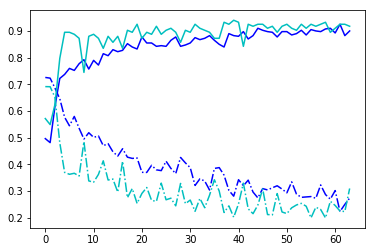

In [147]:
plt.plot(range(len(H.history['loss'])), H.history['acc'], 'b-', H.history['loss'], 'b-.',
         H.history['val_acc'], 'c-', H.history['val_loss'], 'c-.')
plt.show()

### Evaluate model on validation data

In [149]:
E = model.evaluate(x=X_test, y=Y_test)
print(E)

133/133 [==============================] - 2s 13ms/step
[0.3094207285938406, 0.917293233530862]
